In [25]:
import random
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed
from dataclasses import dataclass
from typing import List, Dict
import torch
from torch.optim import AdamW
from IPython.display import HTML, display
from jinja2 import Template
import numpy as np
from enum import Enum

def set_global_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    set_seed(seed)

class CausalDirection(Enum):
    X_TO_Y = "X->Y->theta"
    Y_TO_X = "Y->X->theta"

@dataclass
class ModelConfig:
    model_name: str
    n_prefix_tokens: int = 10
    learning_rate: float = 1e-4
    max_length: int = 1024
    batch_size: int = 16
    num_train_steps: int = 10000
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

class ConceptLearner:
    def __init__(self, config: ModelConfig):
        self.config = config
        self.model = AutoModelForCausalLM.from_pretrained(
            config.model_name,
            output_hidden_states=True,
            output_attentions=True
        ).to(config.device)
        self.tokenizer = AutoTokenizer.from_pretrained(config.model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model.resize_token_embeddings(len(self.tokenizer))

    def compute_token_contributions(self, text: str) -> List[Dict]:
        inputs = self.tokenizer(text, return_tensors="pt").to(self.config.device)
        outputs = self.model(**inputs)

        attentions = outputs.attentions
        layer_contributions = [
            layer_att.mean(dim=1).sum(dim=2)
            for layer_att in attentions
        ]

        num_layers = len(attentions)
        layer_weights = torch.linspace(0.1, 1.0, steps=num_layers).to(self.config.device)
        weighted_contributions = torch.stack(layer_contributions, dim=0) * layer_weights[:, None, None]
        token_contributions = weighted_contributions.sum(dim=0)

        normalized_contributions = token_contributions / token_contributions.sum(dim=1, keepdim=True)

        tokens = self.tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze(0))
        return [{"token": token, "score": float(score)} 
                for token, score in zip(tokens, normalized_contributions.squeeze().tolist())]

    def add_concept_tokens(self, tasks: List[str]) -> List[str]:
        new_tokens = []
        for task in tasks:
            task_tokens = [f"<{task}_token_{i}>" for i in range(self.config.n_prefix_tokens)]
            new_tokens.extend(task_tokens)
        
        self.tokenizer.add_tokens(new_tokens)
        self.model.resize_token_embeddings(len(self.tokenizer))
        return new_tokens

    def train_concept_tokens(self, train_data: List[Dict], tasks: List[str], direction: CausalDirection):
        # Add concept tokens and get their indices
        concept_tokens = self.add_concept_tokens(tasks)
        
        # Get the embedding layer parameters - we want just the new token embeddings
        embed_layer = self.model.get_input_embeddings()
        # Get indices of the new tokens we added
        new_token_ids = [self.tokenizer.convert_tokens_to_ids(token) for token in concept_tokens]
        
        # Create optimizer only for the new token embeddings
        optimizer = AdamW([
            {
                'params': embed_layer.weight[new_token_ids],
                'lr': self.config.learning_rate
            }
        ])

        for step in range(self.config.num_train_steps):
            batch = random.sample(train_data, min(self.config.batch_size, len(train_data)))
            total_loss = torch.tensor(0.0, device=self.config.device)
            
            optimizer.zero_grad()
            
            for item in batch:
                task_idx = tasks.index(item["task"])
                loss = self._compute_batch_loss(item, concept_tokens[task_idx], direction)
                loss = loss / len(batch)  # Normalize by batch size
                total_loss += loss

            print(f"Loss value: {total_loss.item()}")
            print(f"Grad norms: {[p.grad.norm().item() for p in optimizer.param_groups[0]['params']]}")
            
            total_loss.backward()
            optimizer.step()

    def _compute_batch_loss(self, item: Dict, concept_token: str, direction: CausalDirection) -> torch.Tensor:
        if direction == CausalDirection.X_TO_Y:
            inputs = self._prepare_xy_input(item["text"], concept_token) 
            target_ids = self.tokenizer(item["label"], return_tensors="pt")["input_ids"].to(self.config.device)
        else:
            inputs = self._prepare_yx_input(item["label"], concept_token)
            target_ids = self.tokenizer(item["text"], return_tensors="pt")["input_ids"].to(self.config.device)
        
        outputs = self.model(**inputs)
        # Use CrossEntropyLoss directly on logits
        loss_fct = torch.nn.CrossEntropyLoss()
        shift_logits = outputs.logits[..., :-1, :].contiguous()
        shift_labels = target_ids[..., 1:].contiguous()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        return loss
    # def train_concept_tokens(self, train_data: List[Dict], tasks: List[str], direction: CausalDirection):
    #     concept_tokens = self.add_concept_tokens(tasks)
    #     optimizer = AdamW(
    #         [p for n, p in self.model.named_parameters() if "wte" in n],
    #         lr=self.config.learning_rate
    #     )

    #     for step in range(self.config.num_train_steps):
    #         batch = random.sample(train_data, min(self.config.batch_size, len(train_data)))
    #         total_loss = torch.tensor(0.0, device=self.config.device)

    #         for item in batch:
    #             loss = self._compute_batch_loss(item, concept_tokens[tasks.index(item["task"])], direction)
    #             total_loss += loss

    #         optimizer.zero_grad()
            
    #         total_loss.backward()

    #         for param_group in optimizer.param_groups:
    #             for param in param_group['params']:
    #                 if param.grad is None:
    #                     continue
    #                 else:
    #                     print(param.grad)
    #         optimizer.step()

    # def _compute_batch_loss(self, item: Dict, concept_token: str, direction: CausalDirection) -> torch.Tensor:
    #     if direction == CausalDirection.X_TO_Y:
    #         inputs = self._prepare_xy_input(item["text"], concept_token)
    #         labels = self.tokenizer(item["label"], return_tensors="pt")["input_ids"].to(self.config.device)
    #     else:
    #         inputs = self._prepare_yx_input(item["label"], concept_token)
    #         labels = self.tokenizer(item["text"], return_tensors="pt")["input_ids"].to(self.config.device)

    #     outputs = self.model(**inputs, labels=labels)
    #     return outputs.loss

    def _prepare_xy_input(self, text: str, concept_token: str) -> Dict[str, torch.Tensor]:
        inputs = self.tokenizer(f"{concept_token} {text}", return_tensors="pt")
        return {k: v.to(self.config.device) for k, v in inputs.items()}

    def _prepare_yx_input(self, label: str, concept_token: str) -> Dict[str, torch.Tensor]:
        inputs = self.tokenizer(f"{concept_token} {label}", return_tensors="pt")
        return {k: v.to(self.config.device) for k, v in inputs.items()}

class DemonstrationSelector:
    def __init__(self, concept_learner: ConceptLearner):
        self.concept_learner = concept_learner

    def select_demonstrations(self, candidates: List[Dict], k: int):
        scores = [(self._compute_concept_score(c), c) for c in candidates]
        # Extract just the scores for normalization
        score_values = [s for s, _ in scores]
        
        # Find min and max scores
        min_score = min(score_values)
        max_score = max(score_values)
        
        # Handle edge case where all scores are the same
        if max_score == min_score:
            return [(1.0, concept) for _, concept in scores]
        
        # Normalize scores using min-max normalization
        scores = [
            ((s - min_score) / (max_score - min_score), c)
            for s, c in scores
        ]
        scores.sort(reverse=True, key=lambda x: x[0])
        return [c for _, c in scores[:k]], [s for s, _ in scores[:k]]

    def _compute_concept_score(self, candidate: Dict):
        inputs = self.concept_learner.tokenizer(candidate["demonstration"], return_tensors="pt")
        outputs = self.concept_learner.model(**inputs)
        logits = outputs.logits[:, :-1, :]
        probs = torch.softmax(logits, dim=-1)
        target_ids = self.concept_learner.tokenizer(candidate["label"], return_tensors="pt")["input_ids"].squeeze(0)
        scores = [probs[0, i, target_id].item() for i, target_id in enumerate(target_ids)]
        return sum(scores) / len(scores)

    def evaluate_demonstrations(self, test_set: List[Dict], selected_demos: List[Dict]):
        total_loss = 0
        for example in test_set:
            inputs = self.concept_learner.tokenizer(
                selected_demos + [example["demonstration"]], return_tensors="pt", truncation=True
            )
            outputs = self.concept_learner.model(**inputs, labels=inputs["input_ids"])
            total_loss += outputs.loss.item()
        avg_loss = total_loss / len(test_set)
        print(f"Evaluation Loss: {avg_loss}")
        return avg_loss

class DashboardVisualizer:
    def __init__(self, demonstration_scores):
        self.demonstration_scores = demonstration_scores

    def create_dashboard(self):
        html_template = '''
        <div style="font-family: Arial, sans-serif; max-width: 900px; margin: 20px auto;">
            <style>
                .section-title { font-weight: bold; margin: 10px 0; color: #2c5282; font-size: 20px; }
                .demonstration-card { margin: 10px 0; padding: 15px; border-radius: 8px; background-color: #f8f9fa; border: 1px solid #ddd; }
                .demonstration-header { font-size: 16px; font-weight: bold; color: #2c5282; margin-bottom: 10px; }
                .token-container { margin-top: 10px; display: flex; flex-wrap: wrap; }
                .token { display: inline-block; margin: 5px; padding: 5px 8px; border-radius: 4px; font-size: 14px; position: relative; cursor: pointer; background-color: rgb(255, 255, 255); }
                .token[data-score] { background-color: rgba(255, 69, 0, calc(var(--score) * 0.8 + 0.2)); color: black; }
                .token:hover { background-color: rgba(255, 0, 0, 1); }
                .token:hover .tooltip { display: block; }
                .tooltip { display: none; position: absolute; top: -30px; left: 50%; transform: translateX(-50%); background-color: #333; color: white; padding: 5px 8px; border-radius: 4px; font-size: 12px; z-index: 10; }
            </style>
            <div class="section-title">Selected Demonstrations and Token Contributions</div>
            <div id="demonstration-container">
                {% for demo in demonstration_scores %}
                <div class="demonstration-card">
                    <div class="demonstration-header">Demonstration Score: {{ "%.3f"|format(demo.score) }}</div>
                    <div>
                        <b>Token Contributions:</b>
                        <div class="token-container">
                            {% for token in demo.token_contributions %}
                            <div class="token" style="--score: {{ token.score }}" data-score="{{ token.score }}">
                                {{ token.token }}
                                <span class="tooltip">Score: {{ "%.2f"|format(token.score) }}</span>
                            </div>
                            {% endfor %}
                        </div>
                    </div>
                </div>
                {% endfor %}
            </div>
        </div>
        '''
        template = Template(html_template)
        rendered_html = template.render(demonstration_scores=self.demonstration_scores)
        display(HTML(rendered_html))


set_global_seed(42)
config = ModelConfig(model_name="gpt2-xl", n_prefix_tokens=5, learning_rate=1e-4)
concept_learner = ConceptLearner(config)
demonstration_selector = DemonstrationSelector(concept_learner)

candidates = [
    {"demonstration": "The movie was great.", "label": "positive"},
    {"demonstration": "The book was boring.", "label": "negative"},
    {"demonstration": "The article explained AI clearly.", "label": "informative"},
    {"demonstration": "The novel was thrilling.", "label": "exciting"},
]

selected_demos, selected_demos_scores = demonstration_selector.select_demonstrations(candidates, k=3)
demonstration_scores = []
for demo, demo_score in zip(selected_demos, selected_demos_scores):
    tokens = demo["demonstration"]
    token_contributions = concept_learner.compute_token_contributions(tokens)
    # token_contributions = [{"token": token, "score": random.uniform(0, 1)} for token in tokens]
    demonstration_scores.append({"score": demo_score, "token_contributions": token_contributions})

dashboard = DashboardVisualizer(demonstration_scores=demonstration_scores)
dashboard.create_dashboard()



# Understanding LLMs as Latent Variable Models

This paper proposes treating LLMs as latent variable models that can automatically learn and use task concepts to select better demonstrations.

## Framework Steps

### 1. Latent Concept Learning
**Goal**: Learn task-specific concept tokens that capture what makes examples good demonstrations.

**How it works**:
- Add new "concept tokens" to the model's vocabulary 
- Fine-tune only these new token embeddings on the task
- Model learns to encode task information in these tokens
- Can be done with a smaller proxy model (like GPT-2) to save compute

**Mathematically**:
$L(\hat{\theta}^d) = \mathbb{E}_{X,Y}[\ell(X, Y; \hat{\theta}^d)]$

where $\hat{\theta}^d$ represents the learned concept tokens for task d.

### 2. Smart Sample Selection
**Goal**: Find the best examples to use as demonstrations.

**How it works**:
- For each potential demonstration in validation set
- Check how likely it is to generate the learned concept tokens
- Select examples with highest probability
- These examples best represent the task concept

**Key Metric**:
$P_M^d(\hat{\theta}^d|w_{1:t})$ - Probability of concept tokens given the input

### 3. Probability Calculation
**Goal**: Understand how well demonstrations capture task information.

**How it works**:
- Model integrates over all possible task concepts
- Learned concept tokens help guide this integration
- Higher probability means better demonstration quality

**Core Equation**:
$P_M^d(w_{t+1:T}|w_{1:t}) = \int_{\Theta} P_M^d(w_{t+1:T}|\theta)P_M^d(\theta|w_{1:t})d\theta$

### 4. Using with Any LLM
**Goal**: Apply selected demonstrations to improve any LLM's performance.

**How it works**:
- Take best demonstrations found using small proxy model
- Use them as examples in prompt for any larger LLM
- No need to retrain or modify target LLM
- Works because demonstrations capture fundamental task concepts

**Benefits**:
- Automated selection process
- More optimal demonstrations
- Better task performance
- Transferable across different LLMs


In [ ]:
import torch
import random
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed
from dataclasses import dataclass
from typing import List, Dict
from enum import Enum
import numpy as np
from torch.optim import AdamW

def set_global_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    set_seed(seed)

class CausalDirection(Enum):
    X_TO_Y = "X->Y->theta"
    Y_TO_X = "Y->X->theta"

@dataclass
class ModelConfig:
    model_name: str
    n_prefix_tokens: int = 10
    learning_rate: float = 1e-4
    max_length: int = 1024
    batch_size: int = 16
    num_train_steps: int = 1
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

class ConceptLearner:
    def __init__(self, config: ModelConfig):
        self.config = config
        self.model = AutoModelForCausalLM.from_pretrained(
            config.model_name,
            output_hidden_states=True,
            output_attentions=True
        ).to(config.device)
        self.tokenizer = AutoTokenizer.from_pretrained(config.model_name)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model.resize_token_embeddings(len(self.tokenizer))

    def add_concept_tokens(self, tasks: List[str]) -> List[str]:
        new_tokens = []
        for task in tasks:
            task_tokens = [f"<{task}_token_{i}>" for i in range(self.config.n_prefix_tokens)]
            new_tokens.extend(task_tokens)
        
        self.tokenizer.add_tokens(new_tokens)
        self.model.resize_token_embeddings(len(self.tokenizer))
        return new_tokens

    def train_concept_tokens(self, train_data: List[Dict], tasks: List[str], direction: CausalDirection):
        # Add concept tokens and get their indices
        concept_tokens = self.add_concept_tokens(tasks)
        
        # Get the embedding layer
        embed_layer = self.model.get_input_embeddings()
        
        # Create parameter groups for the optimizer - only optimize the embedding weights
        optimizer = AdamW([
            {'params': embed_layer.weight, 'lr': self.config.learning_rate}
        ])

        # Create a mask for the embeddings we want to train
        new_token_ids = torch.tensor([
            self.tokenizer.convert_tokens_to_ids(token) 
            for token in concept_tokens
        ], device=self.config.device)
        
        # Create a mask for freezing gradients of tokens we don't want to train
        grad_mask = torch.zeros_like(embed_layer.weight, dtype=torch.bool)
        grad_mask[new_token_ids] = True

        for step in range(self.config.num_train_steps):
            batch = random.sample(train_data, min(self.config.batch_size, len(train_data)))
            total_loss = torch.tensor(0.0, device=self.config.device)
            
            optimizer.zero_grad()
            
            for item in batch:
                loss = self._compute_batch_loss(item, concept_tokens, direction, tasks)
                loss = loss / len(batch)  # Normalize by batch size
                total_loss += loss
            
            total_loss.backward()
            
            # Zero out gradients for tokens we don't want to train
            embed_layer.weight.grad[~grad_mask] = 0
            
            optimizer.step()
            
            if step % 200 == 0:
                print(f"Step {step}, Loss: {total_loss.item()}")

    def _compute_batch_loss(self, item: Dict, concept_tokens: List[str], direction: CausalDirection, tasks: List[str]) -> torch.Tensor:
        task_idx = tasks.index(item["task"])
        concept_token = concept_tokens[task_idx]

        # We will combine X and Y into one sequence for language modeling.
        # If direction == X_TO_Y, the model sees concept_token + X + Y+<eos> as input 
        # and tries to predict each next token.
        if direction == CausalDirection.X_TO_Y:
            sequence = f"{concept_token} {item['text']} {item['label']} {self.tokenizer.eos_token}"
        else:
            sequence = f"{concept_token} {item['label']} {item['text']} {self.tokenizer.eos_token}"

        inputs = self.tokenizer(sequence, return_tensors="pt", truncation=True, max_length=self.config.max_length).to(self.config.device)
        
        # For language modeling, targets are the same as inputs (shifted by one)
        target_ids = inputs["input_ids"]

        outputs = self.model(**inputs)
        
        # Next-token prediction: shift the inputs
        shift_logits = outputs.logits[..., :-1, :].contiguous()   # [batch, seq_length-1, vocab]
        shift_labels = target_ids[..., 1:].contiguous()           # [batch, seq_length-1]

        loss_fct = torch.nn.CrossEntropyLoss()
        return loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

    def compute_token_contributions(self, text: str, concept_tokens: List[str]) -> List[Dict]:
        # Add concept tokens at the start of the sequence 
        concept_input = f"{' '.join(concept_tokens)} {text}"
        inputs = self.tokenizer(concept_input, return_tensors="pt", truncation=True, 
                            max_length=self.config.max_length).to(self.config.device)

        outputs = self.model(**inputs, output_attentions=True, output_hidden_states=True)
        attentions = outputs.attentions
        input_ids = inputs["input_ids"].squeeze(0)
        tokens = self.tokenizer.convert_ids_to_tokens(input_ids)
        
        # The concept tokens are the first n tokens
        concept_positions = list(range(len(concept_tokens)))
        
        # Compute token importance using attention patterns
        num_layers = len(attentions)
        token_contributions = torch.zeros(input_ids.size(0), device=self.config.device)
        
        for layer_idx, layer_attention in enumerate(attentions):
            avg_attention = layer_attention.mean(dim=1)  # (batch, seq_len, seq_len)
            
            # Look at attention FROM concept token positions 
            concept_attention = avg_attention[:, concept_positions, :]
            
            # Aggregate contributions
            token_scores = concept_attention.sum(dim=1)
            token_contributions += token_scores.squeeze(0)
        
        # Normalize
        token_contributions /= token_contributions.sum()
        
        return [{"token": token, "score": float(score)} 
                for token, score in zip(tokens, token_contributions.tolist())]
    

# Main execution
set_global_seed(42)
config = ModelConfig(model_name="gpt2", n_prefix_tokens=5, learning_rate=0)
concept_learner = ConceptLearner(config)

# Prepare training data
train_data = [
    {"text": "The movie was great.", "label": "positive", "task": "sentiment"},
    {"text": "The book was boring.", "label": "negative", "task": "sentiment"},
    {"text": "The article explained AI clearly.", "label": "informative", "task": "sentiment"},
    {"text": "The novel was thrilling.", "label": "exciting", "task": "sentiment"}
]


# First train the model with concept tokens
concept_tokens = concept_learner.add_concept_tokens(tasks=["sentiment"])
concept_learner.train_concept_tokens(train_data, tasks=["sentiment"], direction=CausalDirection.X_TO_Y)

# Then analyze contributions
test_text = "The movie was great."
contributions = concept_learner.compute_token_contributions(test_text, concept_tokens)
for c in contributions:
    print(c)


Step 0, Loss: 8.225733757019043
{'token': '<sentiment_token_0>', 'score': 0.7581888437271118}
{'token': 'Ġ', 'score': 0.06689581274986267}
{'token': '<sentiment_token_1>', 'score': 0.1064826026558876}
{'token': 'Ġ', 'score': 0.0388786718249321}
{'token': '<sentiment_token_2>', 'score': 0.02955404669046402}
{'token': 'Ġ', 'score': 0.0}
{'token': '<sentiment_token_3>', 'score': 0.0}
{'token': 'Ġ', 'score': 0.0}
{'token': '<sentiment_token_4>', 'score': 0.0}
{'token': 'ĠThe', 'score': 0.0}
{'token': 'Ġmovie', 'score': 0.0}
{'token': 'Ġwas', 'score': 0.0}
{'token': 'Ġgreat', 'score': 0.0}
{'token': '.', 'score': 0.0}


In [ ]:
import torch
import random
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed
from dataclasses import dataclass
from typing import List, Dict
from enum import Enum
import numpy as np
from torch.optim import AdamW

def set_global_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    set_seed(seed)

class CausalDirection(Enum):
    X_TO_Y = "X->Y->theta"
    Y_TO_X = "Y->X->theta"

@dataclass
class ModelConfig:
    model_name: str
    n_prefix_tokens: int = 10
    learning_rate: float = 1e-4
    max_length: int = 1024
    batch_size: int = 16
    num_train_steps: int = 1
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

class ConceptLearner:
    def __init__(self, config: ModelConfig):
        self.config = config
        self.model = AutoModelForCausalLM.from_pretrained(
            config.model_name,
            output_hidden_states=True,
            output_attentions=True
        ).to(config.device)
        self.tokenizer = AutoTokenizer.from_pretrained(config.model_name)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model.resize_token_embeddings(len(self.tokenizer))

    def add_concept_tokens(self, tasks: List[str]) -> List[str]:
        new_tokens = [f"<{task}_token_{i}>" for task in tasks for i in range(self.config.n_prefix_tokens)]
        self.tokenizer.add_tokens(new_tokens)
        self.model.resize_token_embeddings(len(self.tokenizer))

        # Initialize new token embeddings with the mean of pre-trained embeddings
        embed_layer = self.model.get_input_embeddings()
        new_token_ids = [self.tokenizer.convert_tokens_to_ids(token) for token in new_tokens]
        with torch.no_grad():
            mean_embedding = embed_layer.weight.mean(dim=0)
            for token_id in new_token_ids:
                embed_layer.weight[token_id] = mean_embedding

        return new_tokens

    def train_concept_tokens(self, train_data: List[Dict], tasks: List[str], direction: CausalDirection):
        concept_tokens = self.add_concept_tokens(tasks)
        embed_layer = self.model.get_input_embeddings()

        optimizer = AdamW([{'params': embed_layer.weight, 'lr': self.config.learning_rate}])
        new_token_ids = torch.tensor(
            [self.tokenizer.convert_tokens_to_ids(token) for token in concept_tokens],
            device=self.config.device
        )
        
        for step in range(self.config.num_train_steps):
            batch = random.sample(train_data, min(self.config.batch_size, len(train_data)))
            optimizer.zero_grad()
            total_loss = torch.tensor(0.0, device=self.config.device)
            
            for item in batch:
                loss = self._compute_batch_loss(item, direction, concept_tokens)
                total_loss += loss / len(batch)
            
            total_loss.backward()
            
            # Freeze gradients for non-concept tokens
            embed_layer.weight.grad[~torch.isin(torch.arange(embed_layer.weight.size(0), device=self.config.device), new_token_ids)] = 0
            
            optimizer.step()
            
            if step % 200 == 0:
                print(f"Step {step}, Loss: {total_loss.item()}")

    def _compute_batch_loss(self, item: Dict, direction: CausalDirection, concept_tokens: List[str]) -> torch.Tensor:
        task = item["task"]
        concept_token = f"<{task}_concept_0>"
        sequence = (f"{concept_token} {item['text']} {item['label']} {self.tokenizer.eos_token}" 
                    if direction == CausalDirection.X_TO_Y else 
                    f"{concept_token} {item['label']} {item['text']} {self.tokenizer.eos_token}")
        inputs = self.tokenizer(sequence, return_tensors="pt", truncation=True, max_length=self.config.max_length).to(self.config.device)
        target_ids = inputs["input_ids"]
        outputs = self.model(**inputs)
        logits = outputs.logits[..., :-1, :]
        labels = target_ids[..., 1:]
        loss_fn = torch.nn.CrossEntropyLoss()
        return loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))
    
    def compute_token_contributions(self, text: str, concept_tokens: List[str]) -> List[Dict]:
        # Combine concept tokens with the input text
        sequence = f"{' '.join(concept_tokens)} {text}"
        inputs = self.tokenizer(sequence, return_tensors="pt", truncation=True, max_length=self.config.max_length).to(self.config.device)
        outputs = self.model(**inputs, output_attentions=True)
        attentions = outputs.attentions  # (num_layers, batch, num_heads, seq_len, seq_len)
        input_ids = inputs["input_ids"].squeeze(0)
        tokens = self.tokenizer.convert_ids_to_tokens(input_ids)

        # Identify positions of concept tokens
        concept_positions = list(range(len(concept_tokens)))
        contributions = torch.zeros(len(tokens), device=self.config.device)

        # Compute token contributions using attention weights
        for layer_attention in attentions:
            avg_attention = layer_attention.mean(dim=1)  # Average over heads
            concept_attention = avg_attention[:, concept_positions, :]  # Attention FROM concept tokens
            contributions += concept_attention.sum(dim=1).squeeze(0)  # Aggregate attention

        # Normalize contributions
        contributions /= contributions.sum()

        # Exclude non-semantic tokens (e.g., 'Ġ')
        filtered_tokens = []
        filtered_contributions = []
        for token, score in zip(tokens, contributions.tolist()):
            if token.strip() and not token.startswith("Ġ"):  # Exclude empty or space-only tokens
                filtered_tokens.append(token)
                filtered_contributions.append(score)

        # Renormalize filtered contributions
        total_score = sum(filtered_contributions)
        filtered_contributions = [score / total_score for score in filtered_contributions]

        # Return filtered results
        return [{"token": token, "score": score} for token, score in zip(filtered_tokens, filtered_contributions)]


    # def compute_token_contributions(self, text: str, concept_tokens: List[str]) -> List[Dict]:
    #     sequence = f"{' '.join(concept_tokens)} {text}"
    #     inputs = self.tokenizer(sequence, return_tensors="pt", truncation=True, max_length=self.config.max_length).to(self.config.device)
    #     outputs = self.model(**inputs, output_attentions=True)
    #     attentions = outputs.attentions
    #     input_ids = inputs["input_ids"].squeeze(0)
    #     tokens = self.tokenizer.convert_ids_to_tokens(input_ids)
    #     concept_positions = list(range(len(concept_tokens)))
    #     contributions = torch.zeros(len(tokens), device=self.config.device)
        
    #     for layer_attention in attentions:
    #         avg_attention = layer_attention.mean(dim=1)
    #         concept_attention = avg_attention[:, concept_positions, :]
    #         contributions += concept_attention.sum(dim=1).squeeze(0)
        
    #     contributions /= contributions.sum()
    #     return [{"token": token, "score": float(score)} for token, score in zip(tokens, contributions.tolist())]

# Usage Example
set_global_seed(42)
config = ModelConfig(model_name="gpt2", n_prefix_tokens=5)
concept_learner = ConceptLearner(config)

train_data = [
    {"text": "The movie was great.", "label": "positive", "task": "sentiment"},
    {"text": "The book was boring.", "label": "negative", "task": "sentiment"},
    {"text": "The article explained AI clearly.", "label": "informative", "task": "sentiment"},
    {"text": "The novel was thrilling.", "label": "exciting", "task": "sentiment"}
]

tasks = ["sentiment"]
concept_learner.train_concept_tokens(train_data, tasks, direction=CausalDirection.X_TO_Y)

test_text = "The movie was great."
concept_tokens = concept_learner.add_concept_tokens(tasks)
contributions = concept_learner.compute_token_contributions(test_text, concept_tokens)
for c in contributions:
    print(c)


Step 0, Loss: 8.225733757019043
{'token': '<sentiment_concept_0>', 'score': 0.8478765631414027}
{'token': '<sentiment_concept_1>', 'score': 0.1190778129942124}
{'token': '<sentiment_concept_2>', 'score': 0.03304562386438489}
{'token': '<sentiment_concept_3>', 'score': 0.0}
{'token': '<sentiment_concept_4>', 'score': 0.0}
{'token': '.', 'score': 0.0}


In [29]:
contributions

[{'token': '<sentiment_concept_0>', 'score': 0.7581803202629089},
 {'token': 'Ġ', 'score': 0.06690854579210281},
 {'token': '<sentiment_concept_1>', 'score': 0.1064806580543518},
 {'token': 'Ġ', 'score': 0.03888070583343506},
 {'token': '<sentiment_concept_2>', 'score': 0.029549751430749893},
 {'token': 'Ġ', 'score': 0.0},
 {'token': '<sentiment_concept_3>', 'score': 0.0},
 {'token': 'Ġ', 'score': 0.0},
 {'token': '<sentiment_concept_4>', 'score': 0.0},
 {'token': 'ĠThe', 'score': 0.0},
 {'token': 'Ġmovie', 'score': 0.0},
 {'token': 'Ġwas', 'score': 0.0},
 {'token': 'Ġgreat', 'score': 0.0},
 {'token': '.', 'score': 0.0}]

In [60]:
import torch
import random
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed
from dataclasses import dataclass
from typing import List, Dict
from enum import Enum
import numpy as np
from torch.optim import AdamW
from IPython.display import HTML, display
from jinja2 import Template
import numpy as np
from enum import Enum


def clean_tokens(tokens):
    return [token.lstrip('Ġ') for token in tokens if len(token.lstrip('Ġ')) != 0]

def set_global_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    set_seed(seed)

class CausalDirection(Enum):
    X_TO_Y = "X->Y->theta"
    Y_TO_X = "Y->X->theta"

@dataclass
class ModelConfig:
    model_name: str
    n_prefix_tokens: int = 10
    learning_rate: float = 1e-4
    max_length: int = 1024
    batch_size: int = 16
    num_train_steps: int = 1
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

class ConceptLearner:
    def __init__(self, config: ModelConfig):
        self.config = config
        self.model = AutoModelForCausalLM.from_pretrained(
            config.model_name,
            output_hidden_states=True,
            output_attentions=True
        ).to(config.device)
        self.tokenizer = AutoTokenizer.from_pretrained(config.model_name)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model.resize_token_embeddings(len(self.tokenizer))

    def add_concept_tokens(self, tasks: List[str]) -> List[str]:
        # Add one concept token for each task
        new_tokens = [f"<{task}_concept>" for task in tasks]
        self.tokenizer.add_tokens(new_tokens)
        self.model.resize_token_embeddings(len(self.tokenizer))

        # Initialize new token embeddings with the mean of pre-trained embeddings
        embed_layer = self.model.get_input_embeddings()
        new_token_ids = [self.tokenizer.convert_tokens_to_ids(token) for token in new_tokens]
        with torch.no_grad():
            mean_embedding = embed_layer.weight.mean(dim=0)
            for token_id in new_token_ids:
                embed_layer.weight[token_id] = mean_embedding

        return new_tokens


    def train_concept_tokens(self, train_data: List[Dict], tasks: List[str], direction: CausalDirection):
        concept_tokens = self.add_concept_tokens(tasks)
        embed_layer = self.model.get_input_embeddings()

        optimizer = AdamW([{'params': embed_layer.weight, 'lr': self.config.learning_rate}])
        new_token_ids = torch.tensor(
            [self.tokenizer.convert_tokens_to_ids(token) for token in concept_tokens],
            device=self.config.device
        )

        for step in range(self.config.num_train_steps):
            batch = random.sample(train_data, min(self.config.batch_size, len(train_data)))
            optimizer.zero_grad()
            total_loss = torch.tensor(0.0, device=self.config.device)

            for item in batch:
                loss = self._compute_batch_loss(item,  concept_tokens, direction)
                total_loss += loss / len(batch)
            
            total_loss.backward()

            # Regularize attention to prevent concept token dominance
            with torch.no_grad():
                attention_weights = embed_layer.weight.grad[new_token_ids]
                attention_weights = torch.clamp(attention_weights, max=0.1)

            optimizer.step()

            if step % 200 == 0:
                print(f"Step {step}, Loss: {total_loss.item()}")
    def _compute_batch_loss(self, item: Dict, concept_tokens: List[str], direction: CausalDirection) -> torch.Tensor:
        
        concept_token = concept_tokens[0]  # Only one token for the sentiment task

        # Sequence construction
        if direction == CausalDirection.X_TO_Y:
            sequence = f"{concept_token} {item['text']} {item['label']} {self.tokenizer.eos_token}"
        else:
            sequence = f"{concept_token} {item['label']} {item['text']} {self.tokenizer.eos_token}"

        inputs = self.tokenizer(sequence, return_tensors="pt", truncation=True, max_length=self.config.max_length).to(self.config.device)
        target_ids = inputs["input_ids"]

        outputs = self.model(**inputs)
        shift_logits = outputs.logits[..., :-1, :]
        shift_labels = target_ids[..., 1:]

        loss_fct = torch.nn.CrossEntropyLoss()
        return loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

    def compute_token_contributions(self, text: str, concept_tokens: List[str]) -> List[Dict]:
        # Combine concept tokens with the input text
        sequence = f"{' '.join(concept_tokens)} {text}"
        inputs = self.tokenizer(sequence, return_tensors="pt", truncation=True, max_length=self.config.max_length).to(self.config.device)


        print(sequence)
        print(inputs)
        # Obtain embeddings for input tokens and enable gradient computation
        embed_layer = self.model.get_input_embeddings()
        input_embeddings = embed_layer(inputs["input_ids"]).clone().detach().requires_grad_(True)

        # Forward pass using embeddings
        outputs = self.model(inputs_embeds=input_embeddings, output_attentions=True, output_hidden_states=True)
        attentions = outputs.attentions  # Attention weights from the model
        logits = outputs.logits

        # Compute gradient of logits with respect to embeddings
        logits_sum = logits.sum()  # Sum over all logits
        token_grads = torch.autograd.grad(outputs=logits_sum, inputs=input_embeddings, retain_graph=True)[0]

        # Combine contributions across all layers
        layer_contributions = []
        for layer_attention in attentions:
            avg_attention = layer_attention.mean(dim=1)  # Average over heads
            layer_contributions.append(avg_attention * token_grads.norm(dim=-1))  # Combine attention and gradient norms

        # Average contributions across layers
        combined_contributions = torch.stack(layer_contributions).mean(dim=0)  # Average over layers
        contributions = combined_contributions.sum(dim=-1).detach().cpu().numpy()  # Sum contributions per token

        # Normalize contributions
        contributions /= contributions.sum()

        # Map tokens to contributions
        tokens = self.tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze(0))

        tokens = clean_tokens(tokens)
        return [{"token": token, "score": contribution} for token, contribution in zip(tokens, contributions[0])]

class DashboardVisualizer:
    def __init__(self, demonstration_scores):
        self.demonstration_scores = demonstration_scores

    def create_dashboard(self):
        html_template = '''
        <div style="font-family: Arial, sans-serif; max-width: 900px; margin: 20px auto;">
            <style>
                .section-title { font-weight: bold; margin: 10px 0; color: #2c5282; font-size: 20px; }
                .demonstration-card { margin: 10px 0; padding: 15px; border-radius: 8px; background-color: #f8f9fa; border: 1px solid #ddd; }
                .demonstration-header { font-size: 16px; font-weight: bold; color: #2c5282; margin-bottom: 10px; }
                .token-container { margin-top: 10px; display: flex; flex-wrap: wrap; }
                .token { display: inline-block; margin: 5px; padding: 5px 8px; border-radius: 4px; font-size: 14px; position: relative; cursor: pointer; background-color: rgb(255, 255, 255); }
                .token[data-score] { background-color: rgba(255, 69, 0, calc(var(--score) * 0.8 + 0.2)); color: black; }
                .token:hover { background-color: rgba(255, 0, 0, 1); }
                .token:hover .tooltip { display: block; }
                .tooltip { display: none; position: absolute; top: -30px; left: 50%; transform: translateX(-50%); background-color: #333; color: white; padding: 5px 8px; border-radius: 4px; font-size: 12px; z-index: 10; }
            </style>
            <div class="section-title">Selected Demonstrations and Token Contributions</div>
            <div id="demonstration-container">
                {% for demo in demonstration_scores %}
                <div class="demonstration-card">
                    <div class="demonstration-header">Demonstration Score: {{ "%.3f"|format(demo.score) }}</div>
                    <div>
                        <b>Token Contributions:</b>
                        <div class="token-container">
                            {% for token in demo.token_contributions %}
                            <div class="token" style="--score: {{ token.score }}" data-score="{{ token.score }}">
                                {{ token.token }}
                                <span class="tooltip">Score: {{ "%.2f"|format(token.score) }}</span>
                            </div>
                            {% endfor %}
                        </div>
                    </div>
                </div>
                {% endfor %}
            </div>
        </div>
        '''
        template = Template(html_template)
        rendered_html = template.render(demonstration_scores=self.demonstration_scores)
        display(HTML(rendered_html))



# Main execution
set_global_seed(42)
config = ModelConfig(model_name="gpt2", n_prefix_tokens=5)
concept_learner = ConceptLearner(config)

train_data = [
    {"text": "The movie was great.", "label": "positive", "task": "sentiment"},
    {"text": "The book was boring.", "label": "negative", "task": "sentiment"},
    {"text": "The article explained AI clearly.", "label": "informative", "task": "sentiment"},
    {"text": "The novel was thrilling.", "label": "exciting", "task": "sentiment"}
]

tasks = ["sentiment"]
concept_learner.train_concept_tokens(train_data, tasks, direction=CausalDirection.X_TO_Y)

test_text = "The movie was great."
concept_tokens = concept_learner.add_concept_tokens(tasks)
contributions = concept_learner.compute_token_contributions(test_text, concept_tokens)


vis = DashboardVisualizer(contributions)
vis.create_dashboard()
# for c in contributions:
#     print(c)


/Users/lihongxuan/miniconda3/envs/icl/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
/Users/lihongxuan/miniconda3/envs/icl/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


Step 0, Loss: 8.225732803344727
<sentiment_concept> The movie was great.
{'input_ids': tensor([[50257,   383,  3807,   373,  1049,    13]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}


In [ ]:
import torch
import random
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed
from dataclasses import dataclass
from typing import List, Dict
from jinja2 import Template
from IPython.display import display, HTML
import numpy as np
def clean_tokens(tokens):
    return [token.lstrip('Ġ') for token in tokens if len(token.lstrip('Ġ')) != 0]
def set_global_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    set_seed(seed)

@dataclass
class ModelConfig:
    model_name: str
    n_prefix_tokens: int = 1
    learning_rate: float = 1e-4
    max_length: int = 1024
    batch_size: int = 16
    num_train_steps: int = 1000
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

class ConceptLearner:
    def __init__(self, config: ModelConfig):
        self.config = config
        self.model = AutoModelForCausalLM.from_pretrained(
            config.model_name,
            output_hidden_states=True,
            output_attentions=True
        ).to(config.device)
        self.tokenizer = AutoTokenizer.from_pretrained(config.model_name)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model.resize_token_embeddings(len(self.tokenizer))

    def add_concept_tokens(self, tasks: List[str]) -> List[str]:
        # Add one concept token per task
        new_tokens = [f"<{task}_concept>" for task in tasks]
        self.tokenizer.add_tokens(new_tokens)
        self.model.resize_token_embeddings(len(self.tokenizer))

        # Initialize new token embeddings
        embed_layer = self.model.get_input_embeddings()
        new_token_ids = [self.tokenizer.convert_tokens_to_ids(token) for token in new_tokens]
        with torch.no_grad():
            mean_embedding = embed_layer.weight.mean(dim=0)
            for token_id in new_token_ids:
                embed_layer.weight[token_id] = mean_embedding

        return new_tokens

    def train_concept_tokens(self, train_data: List[Dict], tasks: List[str], direction: CausalDirection):
        # Add semantic concept tokens
        concept_tokens = self.add_concept_tokens(tasks)
        embed_layer = self.model.get_input_embeddings()

        # Optimizer to update concept token embeddings
        optimizer = AdamW([{'params': embed_layer.weight, 'lr': self.config.learning_rate}])
        new_token_ids = torch.tensor(
            [self.tokenizer.convert_tokens_to_ids(token) for token in concept_tokens],
            device=self.config.device
        )

        for step in range(self.config.num_train_steps):
            # Create a batch
            batch = random.sample(train_data, min(self.config.batch_size, len(train_data)))
            optimizer.zero_grad()
            total_loss = torch.tensor(0.0, device=self.config.device)

            # Compute the batch loss
            for item in batch:
                loss = self._compute_batch_loss(item, concept_tokens, direction)
                total_loss += loss / len(batch)
            
            # Backpropagate the loss
            total_loss.backward()

            # Regularize gradients for concept token embeddings
            with torch.no_grad():
                concept_grads = embed_layer.weight.grad[new_token_ids]
                concept_grad_norms = concept_grads.norm(dim=-1, keepdim=True)
                embed_layer.weight.grad[new_token_ids] /= concept_grad_norms.clamp(min=1e-8)  # Normalize gradients

            # Step the optimizer
            optimizer.step()

            # Log progress
            if step % 200 == 0:
                print(f"Step {step}, Loss: {total_loss.item()}")
    
    def _compute_batch_loss(self, item: Dict, concept_tokens: List[str], direction: CausalDirection) -> torch.Tensor:
        # Use the first concept token for the task
        concept_token = concept_tokens[0]

        # Construct sequence based on the direction
        if direction == CausalDirection.X_TO_Y:
            sequence = f"{concept_token} {item['text']} {item['label']} {self.tokenizer.eos_token}"
        else:
            sequence = f"{concept_token} {item['label']} {item['text']} {self.tokenizer.eos_token}"

        # Tokenize the sequence
        inputs = self.tokenizer(sequence, return_tensors="pt", truncation=True, max_length=self.config.max_length).to(self.config.device)
        target_ids = inputs["input_ids"]

        # Forward pass through the model
        outputs = self.model(**inputs)
        shift_logits = outputs.logits[..., :-1, :]
        shift_labels = target_ids[..., 1:]

        # Compute the language modeling loss
        loss_fct = torch.nn.CrossEntropyLoss()
        return loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))



    def compute_token_contributions(self, sequence: str) -> List[Dict]:
        inputs = self.tokenizer(sequence, return_tensors="pt", truncation=True, max_length=self.config.max_length).to(self.config.device)
        embed_layer = self.model.get_input_embeddings()
        input_embeddings = embed_layer(inputs["input_ids"]).clone().detach().requires_grad_(True)

        # Forward pass with embeddings
        outputs = self.model(inputs_embeds=input_embeddings, output_attentions=True, output_hidden_states=True)
        attentions = outputs.attentions
        logits = outputs.logits

        # Compute gradient of logits with respect to embeddings
        logits_sum = logits.sum()
        token_grads = torch.autograd.grad(outputs=logits_sum, inputs=input_embeddings, retain_graph=True)[0]

        # Combine contributions
        layer_contributions = []
        for layer_attention in attentions:
            avg_attention = layer_attention.mean(dim=1)  # Average over heads
            layer_contributions.append(avg_attention * token_grads.norm(dim=-1))

        combined_contributions = torch.stack(layer_contributions).mean(dim=0)  # Average across layers
        contributions = combined_contributions.sum(dim=-1).detach().cpu().numpy()
        contributions /= contributions.sum()

        tokens = self.tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze(0))

        tokens = clean_tokens(tokens)
        # print(tokens)
        # cleaned_tokens = [token.lstrip("Ġ") for token in tokens]

        return [{"token": token, "score": contribution} for token, contribution in zip(tokens, contributions[0])]

    def score_demonstrations(self, pool: List[Dict], concept_token: str, test_input: str) -> List[Dict]:
        scores = []
        for demo in pool:
            sequence = f"{concept_token} {demo['text']} {demo['label']} {self.tokenizer.eos_token}"
            inputs = self.tokenizer(sequence, return_tensors="pt", truncation=True, max_length=self.config.max_length).to(self.config.device)
            embed_layer = self.model.get_input_embeddings()
            input_embeddings = embed_layer(inputs["input_ids"]).clone().detach().requires_grad_(True)

            outputs = self.model(inputs_embeds=input_embeddings, output_attentions=True)
            logits = outputs.logits

            # Compute score as gradient norm
            logits_sum = logits.sum()
            token_grads = torch.autograd.grad(outputs=logits_sum, inputs=input_embeddings, retain_graph=True)[0]
            demo_score = token_grads.norm(dim=-1).sum().item()
            scores.append({"demo": demo, "score": demo_score})
        # Normalize scores across the entire pool
        total_score = sum(score["score"] for score in scores)
        for score in scores:
            score["score"] /= total_score

        return sorted(scores, key=lambda x: x["score"], reverse=True)

    def select_top_k_demonstrations(self, pool: List[Dict], concept_token: str, test_input: str, k: int) -> List[Dict]:
        scored_demos = self.score_demonstrations(pool, concept_token, test_input)
        return scored_demos[:k]
    
class DashboardVisualizer:
    def __init__(self, demonstration_scores):
        self.demonstration_scores = demonstration_scores

    def create_dashboard(self):
        html_template = '''
        <div style="font-family: Arial, sans-serif; max-width: 900px; margin: 20px auto;">
            <style>
                .section-title { font-weight: bold; margin: 10px 0; color: #2c5282; font-size: 20px; }
                .demonstration-card { margin: 10px 0; padding: 15px; border-radius: 8px; background-color: #f8f9fa; border: 1px solid #ddd; }
                .demonstration-header { font-size: 16px; font-weight: bold; color: #2c5282; margin-bottom: 10px; }
                .token-container { margin-top: 10px; display: flex; flex-wrap: wrap; }
                .token { display: inline-block; margin: 5px; padding: 5px 8px; border-radius: 4px; font-size: 14px; position: relative; cursor: pointer; background-color: rgb(255, 255, 255); }
                .token[data-score] { background-color: rgba(255, 69, 0, calc(var(--score))); color: black; }
                .token:hover { background-color: rgba(255, 0, 0, 1); }
                .token:hover .tooltip { display: block; }
                .tooltip { display: none; position: absolute; top: -30px; left: 50%; transform: translateX(-50%); background-color: #333; color: white; padding: 5px 8px; border-radius: 4px; font-size: 12px; z-index: 10; }
            </style>
            <div class="section-title">Selected Demonstrations and Token Contributions</div>
            <div id="demonstration-container">
                {% for demo in demonstration_scores %}
                <div class="demonstration-card">
                    <div class="demonstration-header">{{ demo.demo.text }}</div>
                    <div>
                        <b>Token Contributions:</b>
                        <div class="token-container">
                            {% for token in demo.token_contributions %}
                            <div class="token" style="--score: {{ token.scaled_score }}" data-score="{{ token.scaled_score }}">
                                {{ token.token }}
                                <span class="tooltip">Score: {{ "%.2f"|format(token.score) }}</span>
                            </div>
                            {% endfor %}
                        </div>
                    </div>
                </div>
                {% endfor %}
            </div>
        </div>
        '''
        template = Template(html_template)
        rendered_html = template.render(demonstration_scores=self.demonstration_scores)
        display(HTML(rendered_html))

# Main Execution
set_global_seed(42)
config = ModelConfig(model_name="gpt2", n_prefix_tokens=1, num_train_steps=500, learning_rate=1e-4)
concept_learner = ConceptLearner(config)

# Demonstration pool
demonstration_pool = [
    {"text": "The movie was fantastic.", "label": "positive"},
    {"text": "The book was dull.", "label": "negative"},
    {"text": "The article was clear.", "label": "informative"},
    {"text": "The game was thrilling.", "label": "exciting"}
]

# Training data (example)
train_data = [
    {"text": "The movie was thrilling.", "label": "positive", "task": "sentiment"},
    {"text": "The book was boring.", "label": "negative", "task": "sentiment"},
    {"text": "The article explained AI well.", "label": "informative", "task": "sentiment"},
    {"text": "The match was exciting.", "label": "exciting", "task": "sentiment"}
]



# Test input
test_input = "The movie was great."
# Add concept tokens
concept_tokens = concept_learner.add_concept_tokens(["sentiment"])

# Train the model on the concept tokens
concept_learner.train_concept_tokens(train_data, tasks=["sentiment"], direction=CausalDirection.X_TO_Y)

# Select top-K demonstrations
top_k_demos = concept_learner.select_top_k_demonstrations(demonstration_pool, concept_tokens[0], test_input, k=2)

# Prepare `top_k_demos` for visualization
for demo in top_k_demos:
    # Extract text from the nested "demo" dictionary
    text = demo["demo"]["text"]

    # Construct the sequence with the test input and compute contributions
    sequence = f"{concept_tokens[0]} {text} {concept_tokens[0]} {test_input} {concept_learner.tokenizer.eos_token}"
    token_contributions = concept_learner.compute_token_contributions(sequence)

    # Tokenize the full sequence to locate the demonstration text
    tokenized_sequence = concept_learner.tokenizer(sequence, return_tensors="pt", truncation=True)["input_ids"][0]
    tokens = concept_learner.tokenizer.convert_ids_to_tokens(tokenized_sequence)

    # Find tokens between the first and second `<sentiment_concept>` markers
    start_idx = tokens.index("<sentiment_concept>") + 1
    end_idx = tokens.index("<sentiment_concept>", start_idx) - 1

    # Filter contributions to include only tokens between the markers
    filtered_contributions = token_contributions[start_idx:end_idx]

    # Normalize token scores
    total_score = sum(contrib["score"] for contrib in filtered_contributions)
    for contrib in filtered_contributions:
        contrib["score"] /= total_score

    # Enhance and scale token contributions for better visualization
    raw_scores = np.array([contrib["score"] for contrib in filtered_contributions])
    scaled_scores = (raw_scores**2) / (raw_scores**2).max()  # Quadratic scaling
    scaled_scores = 0.2 + 0.8 * scaled_scores  # Map to range [0.2, 1]

    for contrib, scaled_score in zip(filtered_contributions, scaled_scores):
        contrib["scaled_score"] = scaled_score

    # Update `demo` to only include text and filtered, normalized, scaled token contributions
    demo["demo"] = {"text": text}
    demo["token_contributions"] = filtered_contributions

# Visualize
visualizer = DashboardVisualizer(demonstration_scores=top_k_demos)
visualizer.create_dashboard()


Step 0, Loss: 8.226791381835938
Step 200, Loss: 0.8427249789237976
Step 400, Loss: 0.23415812849998474


In [88]:
top_k_demos

[{'demo': {'text': 'The article was clear.'},
  'score': 0.28238546668095915,
  'token_contributions': [{'token': 'The',
    'score': np.float32(0.18388858),
    'scaled_score': np.float32(1.0)},
   {'token': 'article',
    'score': np.float32(0.18083894),
    'scaled_score': np.float32(0.9736853)},
   {'token': 'was',
    'score': np.float32(0.16619962),
    'scaled_score': np.float32(0.8534924)},
   {'token': 'clear',
    'score': np.float32(0.15695323),
    'scaled_score': np.float32(0.7828019)},
   {'token': '.',
    'score': np.float32(0.15534891),
    'scaled_score': np.float32(0.7709484)},
   {'token': '<sentiment_concept>',
    'score': np.float32(0.15677066),
    'scaled_score': np.float32(0.7814468)}]},
 {'demo': {'text': 'The book was dull.'},
  'score': 0.24516247983923464,
  'token_contributions': [{'token': 'The',
    'score': np.float32(0.18041803),
    'scaled_score': np.float32(1.0)},
   {'token': 'book',
    'score': np.float32(0.17398524),
    'scaled_score': np.floa

In [86]:
token_contributions

[{'token': '<sentiment_concept>', 'score': np.float32(0.071037024)},
 {'token': 'The',
  'score': np.float32(0.20560512),
  'scaled_score': np.float32(0.85421455)},
 {'token': 'book',
  'score': np.float32(0.19827428),
  'scaled_score': np.float32(0.80839425)},
 {'token': 'was',
  'score': np.float32(0.18397163),
  'scaled_score': np.float32(0.7237862)},
 {'token': 'dull', 'score': np.float32(0.06638897)},
 {'token': '.', 'score': np.float32(0.06485235)},
 {'token': '<sentiment_concept>', 'score': np.float32(0.06378574)},
 {'token': 'The',
  'score': np.float32(0.2273625),
  'scaled_score': np.float32(1.0)},
 {'token': 'movie', 'score': np.float32(0.07399508)},
 {'token': 'was',
  'score': np.float32(0.18478644),
  'scaled_score': np.float32(0.7284362)},
 {'token': 'great', 'score': np.float32(0.059997387)},
 {'token': '.', 'score': np.float32(0.05712551)},
 {'token': '<|endoftext|>', 'score': np.float32(0.0629154)}]

In [72]:
top_k_demos

[{'demo': {'text': 'The article was clear.'},
  'score': 0.28238546668095915,
  'token_contributions': [{'token': '<sentiment_concept>',
    'score': np.float32(0.07184701)},
   {'token': 'The', 'score': np.float32(0.074176975)},
   {'token': 'article', 'score': np.float32(0.07294681)},
   {'token': 'was', 'score': np.float32(0.0670416)},
   {'token': 'clear', 'score': np.float32(0.06331179)},
   {'token': '.', 'score': np.float32(0.06266464)},
   {'token': '<sentiment_concept>', 'score': np.float32(0.063238144)},
   {'token': 'The', 'score': np.float32(0.081818275)},
   {'token': 'movie', 'score': np.float32(0.076012485)},
   {'token': 'was', 'score': np.float32(0.06556139)},
   {'token': 'great', 'score': np.float32(0.057296697)},
   {'token': '.', 'score': np.float32(0.056295212)},
   {'token': '<|endoftext|>', 'score': np.float32(0.059941214)}]},
 {'demo': {'text': 'The book was dull.'},
  'score': 0.24516247983923464,
  'token_contributions': [{'token': '<sentiment_concept>',
    

In [14]:
text = "movie was great"
inputs = concept_learner.tokenizer(text, return_tensors="pt")
outputs = concept_learner.model(**inputs)
attentions = outputs.attentions  # List of attention tensors (num_layers, batch, num_heads, seq_len, seq_len)
input_ids = inputs["input_ids"].squeeze(0)
tokens = concept_learner.tokenizer.convert_ids_to_tokens(input_ids)

# Initialize cumulative token contributions
num_layers = len(attentions)
token_contributions = torch.zeros(input_ids.size(0))

# Weighted sum of contributions across layers
layer_weights = torch.linspace(0.1, 1.0, steps=num_layers)
for layer_idx, layer_attention in enumerate(attentions):
    # Average attention over heads
    avg_attention = layer_attention.mean(dim=1)  # (batch, seq_len, seq_len)

    # Sum contributions for each token
    token_scores = avg_attention.sum(dim=1)  # (batch, seq_len)
    normalized_scores = token_scores / token_scores.sum(dim=1, keepdim=True)  # Normalize by sequence

    # Weighted by layer importance
    token_contributions += layer_weights[layer_idx] * normalized_scores.squeeze(0)

# Normalize contributions to sum to 1
token_contributions /= token_contributions.sum()


In [15]:
token_contributions

tensor([0.9054, 0.0742, 0.0204], grad_fn=<DivBackward0>)

In [9]:
attentions[0].mean(dim=1).sum(dim=2)

tensor([[1., 1., 1.]], grad_fn=<SumBackward1>)

In [ ]:
contributions = concept_learner.compute_token_contributions(test_text)
        inputs = self.tokenizer(text, return_tensors="pt").to(self.config.device)
        outputs = self.model(**inputs)
        
        attentions = outputs.attentions
        layer_contributions = [
            layer_att.mean(dim=1).sum(dim=2)
            for layer_att in attentions
        ]

/Users/lihongxuan/miniconda3/envs/icl/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


Added 10 new tokens.
Resized token embeddings to 50267 tokens.
Some new concept token embeddings are identical. Please check the token addition process.
Initial concept token embeddings (first 5 tokens):
tensor([[-0.0025, -0.0585,  0.1174,  ...,  0.0236,  0.0039,  0.0344],
        [-0.0025, -0.0585,  0.1174,  ...,  0.0236,  0.0039,  0.0344],
        [-0.0025, -0.0585,  0.1174,  ...,  0.0236,  0.0039,  0.0344],
        [-0.0025, -0.0585,  0.1174,  ...,  0.0236,  0.0039,  0.0344],
        [-0.0025, -0.0585,  0.1174,  ...,  0.0236,  0.0039,  0.0344]])


Preprocessing examples: 100%|██████████| 5/5 [00:00<00:00, 1818.23it/s]


Processing layer 1/12
W_attn shape: torch.Size([768, 2304])
Unexpected W_attn shape in layer 0: torch.Size([768, 2304]), expected (2304, 768)
Processing layer 2/12
W_attn shape: torch.Size([768, 2304])
Unexpected W_attn shape in layer 1: torch.Size([768, 2304]), expected (2304, 768)
Processing layer 3/12
W_attn shape: torch.Size([768, 2304])
Unexpected W_attn shape in layer 2: torch.Size([768, 2304]), expected (2304, 768)
Processing layer 4/12
W_attn shape: torch.Size([768, 2304])
Unexpected W_attn shape in layer 3: torch.Size([768, 2304]), expected (2304, 768)
Processing layer 5/12
W_attn shape: torch.Size([768, 2304])
Unexpected W_attn shape in layer 4: torch.Size([768, 2304]), expected (2304, 768)
Processing layer 6/12
W_attn shape: torch.Size([768, 2304])
Unexpected W_attn shape in layer 5: torch.Size([768, 2304]), expected (2304, 768)
Processing layer 7/12
W_attn shape: torch.Size([768, 2304])
Unexpected W_attn shape in layer 6: torch.Size([768, 2304]), expected (2304, 768)
Proces

Analyzing examples: 100%|██████████| 5/5 [00:00<00:00, 29.36it/s]


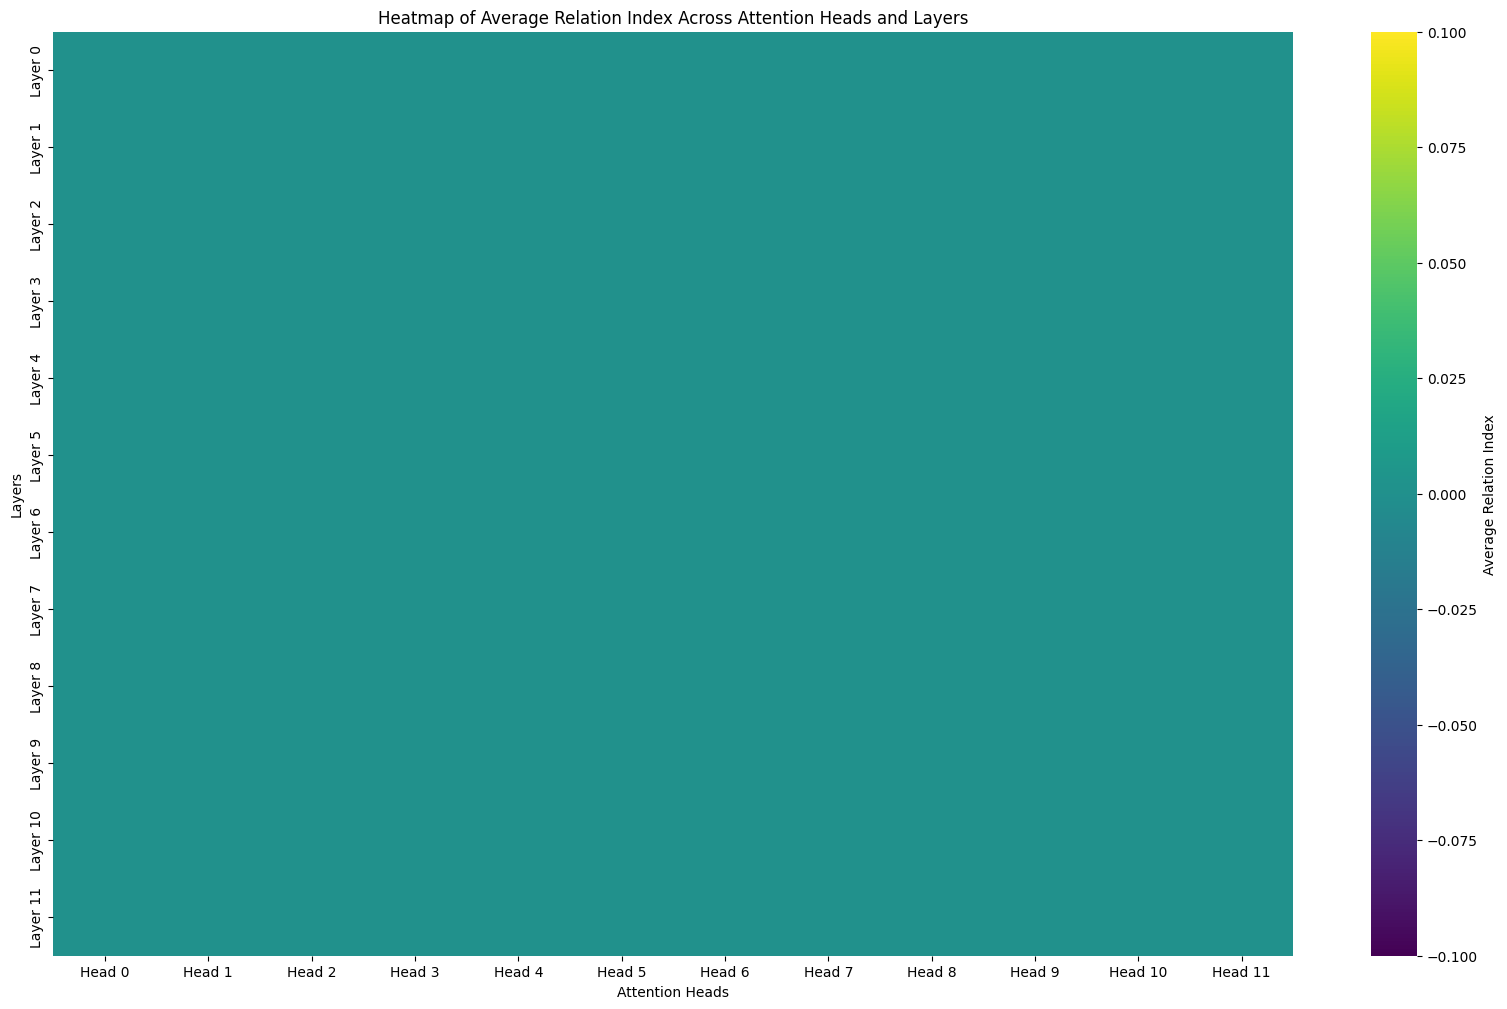

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from tqdm import tqdm

class SemanticICLFramework:
    def __init__(self, model_name, examples, tau=1.0, device=None):
        """
        Initialize the framework with a model and predefined examples.

        Parameters:
            model_name (str): The Hugging Face model name.
            examples (List[Dict]): A list of examples, each containing 'text' and 'triplets'.
            tau (float): Threshold for strong attention focus.
            device (str): Device to run the model on ('cpu' or 'cuda'). Defaults to GPU if available.
        """
        self.model_name = model_name
        self.examples = examples
        self.tau = tau

        # Set device
        if device:
            self.device = torch.device(device)
        else:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load tokenizer and model
        self.tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = GPT2LMHeadModel.from_pretrained(model_name, output_attentions=True)
        self.model.to(self.device)
        self.model.eval()

        # Add new concept tokens
        self.add_concept_tokens()

    def add_concept_tokens(self):
        """
        Add new concept tokens to the tokenizer and resize model embeddings.
        """
        # Define new concept tokens
        self.new_concept_tokens = [f"[CONCEPT{i}]" for i in range(1, 11)]  # [CONCEPT1], [CONCEPT2], ..., [CONCEPT10]

        # Add new tokens to the tokenizer
        num_added_tokens = self.tokenizer.add_tokens(self.new_concept_tokens)
        print(f"Added {num_added_tokens} new tokens.")

        # Resize the model's embeddings to accommodate new tokens
        self.model.resize_token_embeddings(len(self.tokenizer))
        print(f"Resized token embeddings to {len(self.tokenizer)} tokens.")

        # Verify unique embeddings
        self.verify_unique_embeddings()

    def verify_unique_embeddings(self):
        """
        Verify that each new concept token has a unique embedding.
        """
        # Access the token embeddings
        token_embeddings = self.model.get_input_embeddings().weight.data  # Shape: [vocab_size, hidden_size]

        # Get the indices of the new tokens
        new_token_ids = self.tokenizer.convert_tokens_to_ids(self.new_concept_tokens)

        # Extract the embeddings for the new tokens
        new_token_embeddings = token_embeddings[new_token_ids]

        # Check for uniqueness
        uniqueness = (new_token_embeddings[0] != new_token_embeddings[1:]).any(dim=1)
        if uniqueness.all():
            print("All new concept token embeddings are unique.")
        else:
            print("Some new concept token embeddings are identical. Please check the token addition process.")

        # Optional: Print the first 5 embeddings
        print("Initial concept token embeddings (first 5 tokens):")
        print(new_token_embeddings[:5])

    def preprocess_examples(self):
        """
        Preprocess the examples by tokenizing text and preparing triplets.

        Returns:
            List[Dict]: A list of processed examples with tokenized inputs and triplets.
        """
        processed = []
        for example in tqdm(self.examples, desc="Preprocessing examples"):
            tokens = self.tokenizer(
                example["text"],
                truncation=True,
                padding=True,
                return_tensors="pt"
            )
            triplets = example["triplets"]
            processed.append({
                "text": example["text"],
                "tokens": tokens,
                "triplets": triplets
            })
        return processed

    def analyze_attention_heads(self, input_ids, attention_mask):
        """
        Analyze attention heads to retrieve attention matrices.

        Parameters:
            input_ids (torch.Tensor): Token IDs of the input sequence.
            attention_mask (torch.Tensor): Attention mask.

        Returns:
            List[torch.Tensor]: Attention matrices from each layer.
        """
        with torch.no_grad():
            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_attentions=True
            )
        attentions = outputs.attentions  # List of tensors: one for each layer
        return attentions

    def get_token_spans(self, input_ids, token):
        """
        Get all spans (start and end indices) of a token in the input_ids.

        Parameters:
            input_ids (torch.Tensor): Token IDs of the input sequence.
            token (str): The token string to search for.

        Returns:
            List[Tuple[int, int]]: List of (start, end) indices for the token.
        """
        token_ids = self.tokenizer.encode(token, add_special_tokens=False)
        if not token_ids:
            return []

        spans = []
        token_length = len(token_ids)
        input_length = input_ids.size(-1)

        for i in range(input_length - token_length + 1):
            # Compare slices
            slice_ids = input_ids[0, i:i+token_length].tolist()
            if slice_ids == token_ids:
                spans.append((i, i + token_length))
        return spans

    def detect_induction_heads(self, attentions, triplets, input_ids):
        """
        Detect induction heads that strongly focus on head tokens.

        Parameters:
            attentions (List[torch.Tensor]): Attention matrices from each layer.
            triplets (List[Tuple[str, str, str]]): Extracted triplets.
            input_ids (torch.Tensor): Token IDs of the input sequence.

        Returns:
            dict: Mapping of layer index to list of induction head indices.
        """
        induction_heads_per_layer = {}
        for layer_idx, layer_attn in enumerate(attentions):
            num_heads = layer_attn.size(1)
            induction_heads = []
            for head_idx in range(num_heads):
                # Average attention over the batch (assuming batch_size=1)
                avg_attn = layer_attn[0, head_idx, :, :]  # Shape: [seq_len, seq_len]
                for triplet in triplets:
                    head_token = triplet[0]
                    spans = self.get_token_spans(input_ids, head_token)
                    if not spans:
                        continue  # Head token not found in input
                    for (start, end) in spans:
                        # Compute attention scores towards each sub-token of the head token
                        attn_scores = avg_attn[:, start:end].mean(dim=-1)  # Shape: [seq_len]
                        max_attn = torch.max(attn_scores)
                        # Exclude attention to the head token itself when finding other_max
                        # Assuming that the head token can attend to itself
                        # To exclude, set those positions to a very low value
                        attn_scores_excl = attn_scores.clone()
                        attn_scores_excl[start:end] = -float('inf')
                        other_max = torch.max(attn_scores_excl)
                        if other_max.item() == -float('inf'):
                            other_max = 0.0
                        if other_max.item() == 0.0:
                            ratio = float('inf')  # Avoid division by zero
                        else:
                            ratio = max_attn / other_max
                        if ratio > self.tau:
                            induction_heads.append(head_idx)
                            break  # Avoid duplicate additions for multiple spans
            induction_heads_per_layer[layer_idx] = list(set(induction_heads))
        return induction_heads_per_layer

    def extract_W_v_W_o(self):
        """
        Extract W_v and W_o matrices from the model for all layers.

        Returns:
            List[Tuple[torch.Tensor, torch.Tensor]]: List of (W_v, W_o) for each layer.
        """
        W_v_W_o_per_layer = []
        for layer_idx, layer in enumerate(self.model.transformer.h):
            print(f"Processing layer {layer_idx + 1}/{self.model.config.num_hidden_layers}")
            # Each layer has c_attn and c_proj
            c_attn = layer.attn.c_attn  # Linear layer for Q, K, V
            c_proj = layer.attn.c_proj  # Output projection
            W_attn = c_attn.weight.data  # Shape: [3 * hidden_size, hidden_size]
            print(f"W_attn shape: {W_attn.shape}")

            hidden_size = self.model.config.hidden_size
            num_heads = self.model.config.num_attention_heads
            head_dim = hidden_size // num_heads

            # Validate W_attn shape
            expected_W_attn_shape = (3 * hidden_size, hidden_size)
            if W_attn.shape != expected_W_attn_shape:
                print(f"Unexpected W_attn shape in layer {layer_idx}: {W_attn.shape}, expected {expected_W_attn_shape}")
                W_v_W_o_per_layer.append((torch.zeros(num_heads, head_dim, hidden_size).to(self.device), torch.zeros_like(c_proj.weight.data)))
                continue

            # Split W_attn into W_q, W_k, W_v
            W_q = W_attn[:hidden_size, :]
            W_k = W_attn[hidden_size:2*hidden_size, :]
            W_v = W_attn[2*hidden_size:, :]  # Shape: [hidden_size, hidden_size]
            print(f"W_v shape: {W_v.shape}")

            # Split W_v into per-head W_v
            try:
                W_v_heads = W_v.view(num_heads, head_dim, hidden_size)  # Shape: [num_heads, head_dim, hidden_size]
                print(f"W_v_heads shape: {W_v_heads.shape}")
            except RuntimeError as e:
                print(f"Error reshaping W_v in layer {layer_idx}: {e}")
                W_v_heads = torch.zeros(num_heads, head_dim, hidden_size).to(self.device)

            # Store per layer
            W_v_W_o_per_layer.append((W_v_heads, c_proj.weight.data))
        return W_v_W_o_per_layer

    def quantify_influence_on_tail_tokens(self, attentions, induction_heads, triplets, input_ids, W_v_W_o):
        """
        Quantify the influence of induction heads on tail tokens.

        Parameters:
            attentions (List[torch.Tensor]): Attention matrices from each layer.
            induction_heads (dict): Mapping of layer index to list of induction head indices.
            triplets (List[Tuple[str, str, str]]): Extracted triplets.
            input_ids (torch.Tensor): Token IDs of the input sequence.
            W_v_W_o (List[Tuple[torch.Tensor, torch.Tensor]]): List of (W_v, W_o) for each layer.

        Returns:
            dict: Mapping of layer index to {head index: average relation index}.
        """
        relation_indices_per_layer = {layer: {} for layer in induction_heads}
        for layer_idx, heads in induction_heads.items():
            W_v_heads, W_o = W_v_W_o[layer_idx]
            num_heads = W_v_heads.size(0)
            for head_idx in heads:
                W_v = W_v_heads[head_idx]  # Shape: [head_dim, hidden_size]
                # Compute W_ov for this head: [head_dim, hidden_size] @ [hidden_size, hidden_size] = [head_dim, hidden_size]
                W_ov = torch.matmul(W_v, W_o)  # Shape: [head_dim, hidden_size]

                # Get attention scores for the specific head
                attn_scores = attentions[layer_idx][0, head_idx, :, :]  # Shape: [seq_len, seq_len]
                # Apply scaled softmax as per the formulation
                scaled_attn = torch.softmax(attn_scores / np.sqrt(self.model.config.hidden_size), dim=-1)  # Shape: [seq_len, seq_len]

                for triplet in triplets:
                    head_token, relation, tail_token = triplet
                    # Tokenize tail_token
                    tail_token_ids = self.tokenizer.encode(tail_token, add_special_tokens=False)
                    if not tail_token_ids:
                        continue  # Skip if tail_token is not found
                    tail_token_id = tail_token_ids[0]
                    if tail_token_id >= self.model.config.vocab_size:
                        continue  # Invalid token ID

                    # Compute p_h^{j,t_k}
                    # For each token position j, compute p_h^{j,t_k} = softmax(x_j W_ov) [t_k]
                    # Since we don't have x_j (hidden states), we'll approximate p_h^{j,t_k} as the attention weights
                    # multiplied by W_ov and passed through softmax
                    # This is a simplification due to lack of access to intermediate hidden states

                    # Compute logits for t_k
                    logits = torch.matmul(scaled_attn, W_ov)  # Shape: [seq_len, head_dim]
                    # Aggregate head_dim to get a scalar logit per position
                    logits = logits.sum(dim=-1)  # Shape: [seq_len]
                    p_h = torch.softmax(logits, dim=-1)  # Shape: [seq_len]
                    # Identify the position of the head token in the input
                    head_token_ids = self.tokenizer.encode(head_token, add_special_tokens=False)
                    if not head_token_ids:
                        continue
                    head_token_id = head_token_ids[0]
                    # Find all positions where head_token_id appears
                    head_positions = (input_ids == head_token_id).nonzero(as_tuple=True)[0]
                    if len(head_positions) == 0:
                        continue
                    # For simplicity, take the first occurrence
                    head_position = head_positions[0].item()
                    p_h_tk = p_h[head_position].item()

                    # Compute expected p_h over all tokens (mean probability)
                    expected_p = p_h.mean().item()

                    # Compute q_h^{j,t_k}
                    q_h = max(0.0, p_h_tk - expected_p)

                    # Compute a_h^j(T)
                    sum_q_h = q_h if q_h > 0 else 1e-6  # Avoid division by zero
                    a_h = q_h / sum_q_h

                    # Aggregate a_h for the specific head
                    if head_idx not in relation_indices_per_layer[layer_idx]:
                        relation_indices_per_layer[layer_idx][head_idx] = []
                    relation_indices_per_layer[layer_idx][head_idx].append(a_h)
        return relation_indices_per_layer

    def aggregate_relation_indices(self, relation_indices):
        """
        Aggregate the relation indices to determine the importance of each head.

        Parameters:
            relation_indices (dict): Mapping of layer index to {head index: [indices]}.

        Returns:
            dict: Mapping of layer index to {head index: average relation index}.
        """
        aggregated = {}
        for layer, heads in relation_indices.items():
            aggregated[layer] = {}
            for head, indices in heads.items():
                if indices:
                    aggregated[layer][head] = np.mean(indices)
                else:
                    aggregated[layer][head] = 0
        return aggregated

    def collect_all_relation_indices(self, processed_examples):
        """
        Process all examples and collect relation indices.

        Parameters:
            processed_examples (List[Dict]): A list of processed examples.

        Returns:
            dict: Aggregated relation indices across all examples, structured as {layer: {head: average_relation_index}}
        """
        # Initialize a nested structure to hold sum and count for each head
        sum_relation_indices = {}
        count_relation_indices = {}

        # Extract W_v and W_o for all layers
        W_v_W_o = self.extract_W_v_W_o()

        for example in tqdm(processed_examples, desc="Analyzing examples"):
            tokens = example["tokens"]
            input_ids = tokens["input_ids"].to(self.device)
            attention_mask = tokens["attention_mask"].to(self.device)
            triplets = example["triplets"]

            attentions = self.analyze_attention_heads(input_ids, attention_mask)
            induction_heads = self.detect_induction_heads(attentions, triplets, input_ids)
            relation_indices = self.quantify_influence_on_tail_tokens(attentions, induction_heads, triplets, input_ids, W_v_W_o)

            # Aggregate relation indices per head
            for layer, heads in relation_indices.items():
                if layer not in sum_relation_indices:
                    sum_relation_indices[layer] = {}
                    count_relation_indices[layer] = {}
                for head, a_h in heads.items():
                    if head not in sum_relation_indices[layer]:
                        sum_relation_indices[layer][head] = 0.0
                        count_relation_indices[layer][head] = 0
                    sum_relation_indices[layer][head] += a_h
                    count_relation_indices[layer][head] += 1

        # Compute average relation indices per head
        average_relation_indices = {}
        for layer in sum_relation_indices:
            average_relation_indices[layer] = {}
            for head in sum_relation_indices[layer]:
                if count_relation_indices[layer][head] > 0:
                    average_relation_indices[layer][head] = sum_relation_indices[layer][head] / count_relation_indices[layer][head]
                else:
                    average_relation_indices[layer][head] = 0

        return average_relation_indices

    def visualize_heatmap(self, average_relation_indices, num_layers, num_heads):
        """
        Visualize the average relation indices as a heatmap.

        Parameters:
            average_relation_indices (dict): Mapping of layer index to {head index: average relation index}.
            num_layers (int): Total number of layers in the model.
            num_heads (int): Total number of attention heads per layer.
        """
        # Initialize a matrix of zeros
        heatmap_matrix = np.zeros((num_layers, num_heads))

        for layer in range(num_layers):
            for head in range(num_heads):
                if layer in average_relation_indices and head in average_relation_indices[layer]:
                    heatmap_matrix[layer, head] = average_relation_indices[layer][head]
                else:
                    heatmap_matrix[layer, head] = 0

        plt.figure(figsize=(20, 12))
        sns.heatmap(
            heatmap_matrix,
            cmap="viridis",
            xticklabels=[f"Head {h}" for h in range(num_heads)],
            yticklabels=[f"Layer {l}" for l in range(num_layers)],
            cbar_kws={'label': 'Average Relation Index'}
        )
        plt.xlabel("Attention Heads")
        plt.ylabel("Layers")
        plt.title("Heatmap of Average Relation Index Across Attention Heads and Layers")
        plt.show()

    def run_analysis(self):
        """
        Run the full analysis pipeline on all examples and visualize the heatmap.
        """
        processed_examples = self.preprocess_examples()
        average_relation_indices = self.collect_all_relation_indices(processed_examples)
        # Retrieve model configuration for layers and heads
        num_layers = self.model.config.num_hidden_layers
        num_heads = self.model.config.num_attention_heads
        self.visualize_heatmap(average_relation_indices, num_layers, num_heads)

# Example Usage
if __name__ == "__main__":
    # Define simple examples with texts and triplets
    examples = [
        {
            "text": "The pen is used for writing.",
            "triplets": [("pen", "Used-for", "writing")]
        },
        {
            "text": "A cat chases a mouse.",
            "triplets": [("cat", "Chases", "mouse")]
        },
        {
            "text": "The book contains valuable information.",
            "triplets": [("book", "Contains", "information")]
        },
        {
            "text": "She uses a laptop for programming.",
            "triplets": [("laptop", "Used-for", "programming")]
        },
        {
            "text": "The teacher explains the lesson.",
            "triplets": [("teacher", "Explains", "lesson")]
        }
    ]

    # Initialize the framework with the model and examples
    framework = SemanticICLFramework(
        model_name="gpt2",
        examples=examples,
        tau=1.0,  # Lowered threshold for induction heads
        device="cuda" if torch.cuda.is_available() else "cpu"
    )

    # Run the analysis to generate the heatmap
    framework.run_analysis()


In [12]:
token_contributions

[{'token': 'The', 'score': 0.5053552881033624},
 {'token': 'movie', 'score': 0.026535969683863625},
 {'token': 'was', 'score': 0.1988376506866485},
 {'token': 'great.', 'score': 0.6498844377795232}]

In [9]:
selected_demos

[{'demonstration': 'The article explained AI clearly.',
  'label': 'informative'},
 {'demonstration': 'The novel was thrilling.', 'label': 'exciting'},
 {'demonstration': 'The movie was great.', 'label': 'positive'}]